#Load in Files

### Imports

In [1]:
spark.version

u'2.2.0'

In [2]:
import re
import datetime
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType,DateType
import pandas as pd
pd.set_option('display.max_colwidth', 80)


from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import StandardScaler

import numpy as np
import seaborn as sns
sns.set_palette("deep", desat=0.6)
sns.set_context(rc={"figure.figsize": (8,4)})

import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

### Load In NBA Score Data Set

In [3]:
cleaned_dir = '/data2/nba-rt-prediction/sparkfiles/cleanedDF'
df = spark.read.format('csv')\
                    .option("header", "true")\
                    .option("inferSchema", "true")\
                    .option("dateFormat", "yyyy-MM-dd")\
                    .load(cleaned_dir).coalesce(2)

                # For some reason my key is none upon load ! Rebuild
df = df.withColumn("key", concat(date_format(df.dateOrig, "yyyy-MM-dd"),lit("."),col("away_team"),lit("."),col("home_team")))
            
#df.printSchema()
df.toPandas()


,dateOrig,ts,away_team_full,away_score,home_team_full,home_score,timestring,timeleft,away_team,home_team,...,dateStr,away_team_vegas_fscore,home_team_vegas_fscore,final_away_score,final_home_score,away_win,home_win,dfa,outlier,key
0,2016-04-22,23:59:38,San Antonio,95.772358,Memphis,86.804878,(0:56 IN 4TH),1.0,san,mem,...,2016-04-22,96.583333,84.916667,96,87,1,0,-3.389736,0,2016-04-22.san.mem
1,2016-04-22,23:59:38,San Antonio,94.065041,Memphis,85.341463,(0:56 IN 4TH),1.5,san,mem,...,2016-04-22,96.583333,84.916667,96,87,1,0,-2.125254,0,2016-04-22.san.mem
2,2016-04-22,23:59:38,San Antonio,92.357724,Memphis,83.878049,(0:56 IN 4TH),2.0,san,mem,...,2016-04-22,96.583333,84.916667,96,87,1,0,-0.860772,0,2016-04-22.san.mem
3,2016-04-22,23:59:38,San Antonio,90.650407,Memphis,82.414634,(0:56 IN 4TH),2.5,san,mem,...,2016-04-22,96.583333,84.916667,96,87,1,0,0.403709,0,2016-04-22.san.mem
4,2016-04-22,23:52:06,San Antonio,88.888889,Memphis,81.000000,(2:59 IN 4TH),3.0,san,mem,...,2016-04-22,96.583333,84.916667,96,87,1,0,1.673611,0,2016-04-22.san.mem
5,2016-04-22,23:51:05,San Antonio,87.000000,Memphis,81.000000,(3:08 IN 4TH),3.5,san,mem,...,2016-04-22,96.583333,84.916667,96,87,1,0,1.656250,0,2016-04-22.san.mem
6,2016-04-22,23:49:34,San Antonio,83.000000,Memphis,81.000000,(3:41 IN 4TH),4.0,san,mem,...,2016-04-22,96.583333,84.916667,96,87,1,0,3.750000,0,2016-04-22.san.mem
7,2016-04-22,23:48:03,San Antonio,83.000000,Memphis,80.473684,(4:20 IN 4TH),4.5,san,mem,...,2016-04-22,96.583333,84.916667,96,87,1,0,2.370066,0,2016-04-22.san.mem
8,2016-04-22,23:47:33,San Antonio,83.000000,Memphis,78.923077,(4:58 IN 4TH),5.0,san,mem,...,2016-04-22,96.583333,84.916667,96,87,1,0,2.014423,0,2016-04-22.san.mem
9,2016-04-22,23:47:33,San Antonio,83.000000,Memphis,77.769231,(4:58 IN 4TH),5.5,san,mem,...,2016-04-22,96.583333,84.916667,96,87,1,0,1.262019,0,2016-04-22.san.mem


In [4]:
# Create Train / cv or Dev / Test Sets

In [5]:
trainingData, cvData, testData = df.randomSplit([0.6, 0.2, 0.2], seed = 82)
print "Training set size: " + str(trainingData.count())
print "CrossVal set size: " + str(cvData.count())
print "Testing set size: " + str(testData.count())
#print "Distribution of Default and Non-Default in trainingData is: ", trainingData.groupBy("label").count().take(3)


Training set size: 6800
CrossVal set size: 2195
Testing set size: 2375


### Logistic Regression

In [6]:
#Vector Assembler
#feature_cols  = ["home_score", "away_score", "score_diff_amh", "home_team_spread","pct_complete", "cf1", "cf2"]
feature_cols = ["home_score", "away_score", "score_diff_amh", "home_team_spread","pct_complete"]


assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(withMean=False, withStd=False, inputCol="features", outputCol="features_scaled")
# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="home_win", featuresCol="features_scaled", threshold=0.3)
pipeline_lr = Pipeline(stages=[assembler,scaler, lr])
model_lr = pipeline_lr.fit(trainingData)


In [7]:
predictions = model_lr.transform(testData)
lr_evaluator = BinaryClassificationEvaluator(labelCol="home_win",metricName="areaUnderPR")

rf_uroc = lr_evaluator.evaluate(predictions)

print "areaUnderPR for Logistic Regression: " + str(rf_uroc) #0.6918242957971713
print "Cross tab for prediction vs actual table"
model_lr.transform(testData).stat.crosstab("home_win", "prediction").show()

areaUnderPR for Logistic Regression: 0.941923195083
Cross tab for prediction vs actual table
+-------------------+---+----+
|home_win_prediction|0.0| 1.0|
+-------------------+---+----+
|                1.0| 67|1471|
|                0.0|401| 436|
+-------------------+---+----+



### Now search for best hyper parameters

In [8]:
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.001,0.003,0.01,0.03,0.1,0.3])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [100])
             .build())

# Create 5-fold CrossValidator
lr_cv = CrossValidator(estimator=pipeline_lr, estimatorParamMaps=paramGrid, evaluator=lr_evaluator, numFolds=3)

# Run cross validations
lrCvModel = lr_cv.fit(trainingData)

In [9]:
predictions = lrCvModel.transform(testData)
rf_uroc = lr_evaluator.evaluate(predictions)

print "areaUnderPR for Logistic Regression: " + str(rf_uroc) #0.6918242957971713
print "Cross tab for prediction vs actual table"
lrCvModel.transform(testData).stat.crosstab("home_win", "prediction").show()

areaUnderPR for Logistic Regression: 0.942079865694
Cross tab for prediction vs actual table
+-------------------+---+----+
|home_win_prediction|0.0| 1.0|
+-------------------+---+----+
|                1.0| 67|1471|
|                0.0|396| 441|
+-------------------+---+----+



### Linear Regression

In [10]:
from pyspark.ml.regression import LinearRegression
# leverage assembler from above ...
linr_home = LinearRegression(maxIter=100, regParam=0.1, solver="normal", labelCol="final_home_score",featuresCol="features_scaled")
pipeline_linr = Pipeline(stages=[assembler,scaler,linr_home])
model_linr_home = pipeline_linr.fit(trainingData)


In [11]:
predictions = model_linr_home.transform(testData)

linr_home_evaluator = RegressionEvaluator(labelCol="final_home_score",metricName="rmse")

linr_home_rmse = linr_home_evaluator.evaluate(predictions)

print "RMSE for Linear Regression: " + str(linr_home_rmse) 


RMSE for Linear Regression: 15.7604205578


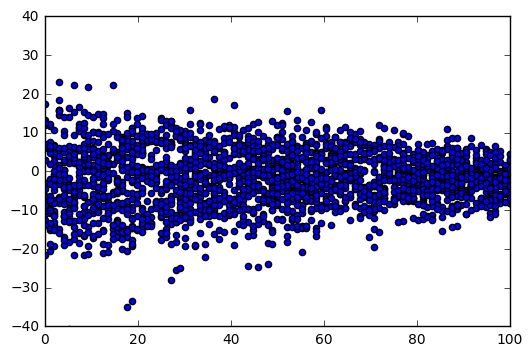

In [12]:
### Plot the residuals
predictions_pd = predictions.toPandas()

plt.xlim(0, 100)
plt.ylim(-40, 40)
plt.scatter(predictions_pd.pct_complete,predictions_pd.prediction-predictions_pd.final_home_score)

### Plot a game result

AttributeError: 'PathCollection' object has no attribute 'legend'

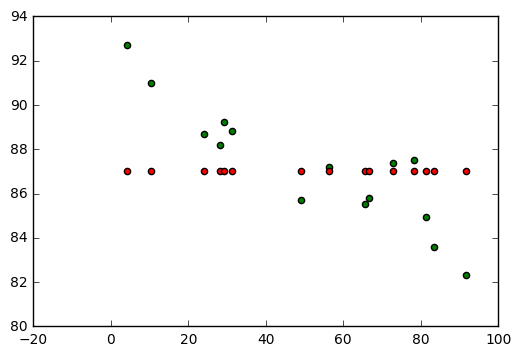

In [20]:
#df[(df.A == 1) & (df.D == 6)]
vis_pd = predictions_pd[predictions_pd.key == "2016-04-22.san.mem"]
plt.figure()
plt.scatter(vis_pd.pct_complete, vis_pd.prediction,c='green')
ax = plt.scatter(vis_pd.pct_complete, vis_pd.final_home_score,c='red')
ax.legend(['1stSerie','2ndSerie'])
#col("key")
#vis_pd


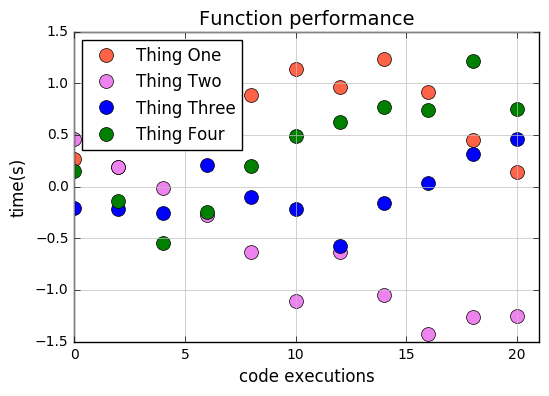

In [22]:
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import numpy as np

# Generate some data
x = np.arange(0, 22, 2)
f1, f2, f3, f4 = np.cumsum(np.random.random((4, x.size)) - 0.5, axis=1)

# It's much more convenient to just use pyplot's factory functions...
fig, ax = plt.subplots()

ax.set_title("Function performance",fontsize=14)
ax.set_xlabel("code executions",fontsize=12)
ax.set_ylabel("time(s)",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

colors = ['tomato', 'violet', 'blue', 'green']
labels = ['Thing One', 'Thing Two', 'Thing Three', 'Thing Four']
for func, color, label in zip([f1, f2, f3, f4], colors, labels):
    ax.plot(x, func, 'o', color=color, markersize=10, label=label)

ax.legend(numpoints=1, loc='upper left')
ax.set_xlim([0, x.max() + 1])

fig.savefig('performance.png', dpi=100)

In [ ]:
Record Results here ...
wo cfs
RMSE for Linear Regression: 15.7604205578
areaUnderROC for Logistic Regression: 0.942079865694
Cross tab for prediction vs actual table
+-------------------+---+----+
|home_win_prediction|0.0| 1.0|
+-------------------+---+----+
|                1.0| 67|1471|
|                0.0|396| 441|
+-------------------+---+----+

w cfs (explore this ... sigh )
RMSE for Linear Regression: 15.7605249792
    areaUnderROC for Logistic Regression: 0.942253516099
Cross tab for prediction vs actual table
+-------------------+---+----+
|home_win_prediction|0.0| 1.0|
+-------------------+---+----+
|                1.0| 67|1471|
|                0.0|395| 442|
+-------------------+---+----+

w cfs + momentum




In [62]:
#pyspark.ml.util.MLWriter

model_linr_home.write().overwrite().save("/data2/nba-rt-prediction/spark_models/model_linr_home")
#model_in = PipelineModel.load(outpath)


In [63]:
predictions_pd

,dateOrig,ts,away_team_full,away_score,home_team_full,home_score,timestring,timeleft,away_team,home_team,...,final_away_score,final_home_score,away_win,home_win,dfa,outlier,key,features,features_scaled,prediction
0,2016-04-05,22:11:45,Portland,3.000000,Sacramento,3.000000,(10:41 IN 1ST),47.0,por,sac,...,115,107,1,0,-1.375000,0,None,"[3.0, 3.0, 0.0, 3.0, 2.08333333333]","[3.0, 3.0, 0.0, 3.0, 2.08333333333]",99.594580
1,2016-04-05,22:14:47,Portland,8.000000,Sacramento,11.681818,(8:15 IN 1ST),44.5,por,sac,...,115,107,1,0,-3.494318,0,None,"[11.6818181818, 8.0, -3.68181818176, 3.0, 7.29166666667]","[11.6818181818, 8.0, -3.68181818176, 3.0, 7.29166666667]",102.184446
2,2016-04-05,22:18:19,Portland,14.000000,Sacramento,17.000000,(6:47 IN 1ST),43.0,por,sac,...,115,107,1,0,-7.875000,0,None,"[17.0, 14.0, -3.0, 3.0, 10.4166666667]","[17.0, 14.0, -3.0, 3.0, 10.4166666667]",104.236155
3,2016-04-05,22:19:51,Portland,15.257143,Sacramento,20.885714,(5:47 IN 1ST),42.0,por,sac,...,115,107,1,0,-8.392857,0,None,"[20.8857142857, 15.2571428571, -5.62857142856, 3.0, 12.5]","[20.8857142857, 15.2571428571, -5.62857142856, 3.0, 12.5]",105.496468
4,2016-04-05,22:23:54,Portland,17.647059,Sacramento,24.000000,(4:24 IN 1ST),40.5,por,sac,...,115,107,1,0,-6.959559,0,None,"[24.0, 17.6470588236, -6.35294117645, 3.0, 15.625]","[24.0, 17.6470588236, -6.35294117645, 3.0, 15.625]",105.311651
5,2016-04-05,22:32:00,Portland,24.000000,Sacramento,26.000000,(2:27 IN 1ST),38.5,por,sac,...,115,107,1,0,-6.062500,0,None,"[26.0, 24.0, -2.0, 3.0, 19.7916666667]","[26.0, 24.0, -2.0, 3.0, 19.7916666667]",103.799135
6,2016-04-05,22:43:08,Portland,34.000000,Sacramento,35.000000,(9:22 IN 2ND),33.5,por,sac,...,115,107,1,0,-1.937500,0,None,"[35.0, 34.0, -1.0, 3.0, 30.2083333333]","[35.0, 34.0, -1.0, 3.0, 30.2083333333]",102.371048
7,2016-04-05,22:44:08,LA Lakers,0.000000,LA Clippers,0.888889,(10:45 IN 1ST),47.0,lal,lac,...,81,103,0,1,2.944444,0,None,"[0.888888888889, 0.0, -0.888888888889, -14.5, 2.08333333333]","[0.888888888889, 0.0, -0.888888888889, -14.5, 2.08333333333]",106.897242
8,2016-04-05,22:47:41,Portland,39.516129,Sacramento,37.000000,(7:37 IN 2ND),32.0,por,sac,...,115,107,1,0,-2.516129,0,None,"[37.0, 39.5161290322, 2.5161290322, 3.0, 33.3333333333]","[37.0, 39.5161290322, 2.5161290322, 3.0, 33.3333333333]",101.734789
9,2016-04-05,22:49:12,Portland,44.000000,Sacramento,40.545455,(6:52 IN 2ND),31.0,por,sac,...,115,107,1,0,-5.920455,0,None,"[40.5454545456, 44.0, 3.45454545445, 3.0, 35.4166666667]","[40.5454545456, 44.0, 3.45454545445, 3.0, 35.4166666667]",103.168981
